## Boilerplate

In [1]:
import sys
import subprocess
import os
import json
from pathlib import Path

if 'google.colab' in sys.modules:
    print("Running on Colab")

    subprocess.run([
        'git', 'clone', 'https://github.com/walligot/don_thesis.git'
    ])

    os.chdir('/content/don_thesis')
    #%pip install git+https://github.com/mitchellostrow/DSA.git
    %pip install git+https://github.com/Melina-Jingting/foundational_ssm.git

    from google.colab import drive
    drive.mount('/content/drive')

    os.environ['HOME'] = '/content/drive/MyDrive/Thesis'
    ROOT_PATH = '/content/don_thesis'
    os.environ['ROOT_PATH'] = ROOT_PATH

    wandb_config_path = '/content/drive/MyDrive/Colab/wandb.config.json'

else:
    #%pip install git+https://github.com/mitchellostrow/DSA.git

    current_path = Path().resolve()
    ROOT_PATH = None
    for parent in [current_path] + list(current_path.parents):
        if "don_thesis" in parent.name.lower():
            ROOT_PATH = parent
            os.environ['ROOT_PATH'] = str(ROOT_PATH)
            break

    if not ROOT_PATH:
        raise FileNotFoundError("Directory with name 'don_thesis' not found.")

    print("Running locally or elsewhere")
    wandb_config_path = os.path.join(os.environ['ROOT_PATH'], 'config', 'wandb.config.json')

# Set WANDB_CONFIG_PATH
os.environ['WANDB_CONFIG_PATH'] = wandb_config_path

# Load API key from JSON
with open(wandb_config_path) as f:
    config = json.load(f)
    os.environ['WANDB_API_KEY'] = config['WANDB_API_KEY']

%pip install pynwb
%pip install equinox
#%pip install equinox==0.12.2 jax==0.7.0 jaxlib==0.7.0

sys.path.append('/content/don_thesis/src')
print(f"Root path: {ROOT_PATH}")
print(f"WANDB config path: {wandb_config_path}")


Running on Colab
  Cloning https://github.com/Melina-Jingting/foundational_ssm.git to /tmp/pip-req-build-von3794w
  Running command git clone --filter=blob:none --quiet https://github.com/Melina-Jingting/foundational_ssm.git /tmp/pip-req-build-von3794w
  Resolved https://github.com/Melina-Jingting/foundational_ssm.git to commit 0946f85db8cb835434ac12f50e22c187e8824699
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

## Load Data

### Load Model Checkpoints

In [2]:
import wandb
import equinox as eqx
import os

# Foundational SSM imports
from omegaconf import OmegaConf
import tempfile
from foundational_ssm.models import SSMDownstreamDecoder

import wandb
import equinox as eqx
import os

# Foundational SSM imports
from omegaconf import OmegaConf
import tempfile
from foundational_ssm.models import SSMDownstreamDecoder, SSMFoundationalDecoder
from foundational_ssm.utils import h5_to_dict
from foundational_ssm.transform import smooth_spikes
import jax
import jax.numpy as jnp
import numpy as np
from typing import Any, BinaryIO

def load_model_and_state_from_checkpoint_wandb_old(artifact_full_name, model_cls=SSMDownstreamDecoder):
    """Load model, optimizer state, epoch, and step from a checkpoint file."""
    api = wandb.Api()
    try:
        artifact = api.artifact(artifact_full_name, type="checkpoint")
    except Exception as e:
        raise FileNotFoundError(f"Could not find checkpoint artifact: {artifact_full_name}")

    run = artifact.logged_by()
    run_cfg = OmegaConf.create(run.config)
    model_cfg = OmegaConf.create(run_cfg.model)
    model_template, state_template = eqx.nn.make_with_state(model_cls)(
        **model_cfg,
    )

    with tempfile.TemporaryDirectory() as temp_dir:
        artifact.download(temp_dir)
        model = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "model.ckpt"), model_template)
        state = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "state.ckpt"), state_template)

    meta = artifact.metadata
    return model, state, meta

def default_deserialise_filter_spec(f: BinaryIO, x: Any) -> Any:
    """Default filter specification for deserialising saved data.

    **Arguments**

    -   `f`: file-like object
    -   `x`: The leaf for which the data needs to be loaded.

    **Returns**

    The new value for datatype `x`.

    !!! info

        This function can be extended to customise the deserialisation behaviour for
        leaves.

    !!! example

        Skipping loading of jax.Array.

        ```python
        import jax.numpy as jnp
        import equinox as eqx

        tree = (jnp.array([4,5,6]), [1,2,3])
        new_filter_spec = lambda f,x: (
            x if isinstance(x, jax.Array) else eqx.default_deserialise_filter_spec(f, x)
        )
        new_tree = eqx.tree_deserialise_leaves("some_filename.eqx", tree, filter_spec=new_filter_spec)
        ```
    """  # noqa: E501
    try:
        if isinstance(x, (jax.Array, jax.ShapeDtypeStruct)):
            return jnp.load(f)
        elif isinstance(x, np.ndarray):
            # Important to use `np` here to avoid promoting NumPy arrays to JAX.
            return np.load(f)
        elif eqx.is_array_like(x):
            # np.generic gets deserialised directly as an array, so convert back to a scalar
            # type here.
            # See also https://github.com/google/jax/issues/17858
            out = np.load(f)
            if isinstance(x, jax.dtypes.bfloat16):
                out = out.view(jax.dtypes.bfloat16)
            if np.size(out) == 1:
                return type(x)(out.item())
        else:
            return x
    except:
        print("Failed to load data for leaf with shape/ value:", x.shape if hasattr(x, 'shape') else x)
        return x

def load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMDownstreamDecoder, model_cfg=None):
    """Load model, optimizer state, epoch, and step from a checkpoint file."""
    api = wandb.Api()
    try:
        artifact = api.artifact(artifact_full_name, type="checkpoint")
    except Exception as e:
        raise FileNotFoundError(f"Could not find checkpoint artifact: {artifact_full_name}")

    if model_cfg is None:
        run = artifact.logged_by()
        run_cfg = OmegaConf.create(run.config)
        print(run_cfg)
        model_cfg = OmegaConf.create(run_cfg.model)

    model_template, state_template = eqx.nn.make_with_state(model_cls)(
        **model_cfg
    )

    with tempfile.TemporaryDirectory() as temp_dir:
        artifact.download(temp_dir)
        model = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "model.ckpt"), model_template, default_deserialise_filter_spec)
        state = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "state.ckpt"), state_template, default_deserialise_filter_spec)

    meta = artifact.metadata
    model = eqx.nn.inference_mode(model)
    return model, state, meta

# rtt task models
layer = "2"
pretrain_mode = "scratch"
train_mode = "all"
#alias = "latest" # can be latest/best/ epoch_{any value in range(0,1000,100)}
# epoch 0 now stores a fresh model.
artifact_full_name_trained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:best"
artifact_full_name_untrained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:epoch_0"
rtt_2block_model, trained_state, trained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_trained)
rtt_2block_untrained_model, untrained_state, untrained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_untrained)

layer = "4"
artifact_full_name_trained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:best"
artifact_full_name_untrained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:epoch_0"
#rtt_4block_model, trained_state, trained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_trained)
#rtt_4block_untrained_model, untrained_state, untrained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_untrained)

model = "l2"
#dataset = "similar_task"
#dataset = "reaching_normalized"
dataset = "reaching"
#alias = "best"
alias = "latest"

# Foundational Models
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_2block_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

alias = "epoch_0"
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_2block_untrained_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

model = "l4"
#alias = "best"
alias = "latest"
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_4block_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

alias = "epoch_0"
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_4block_untrained_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: davekk (davekk-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'training.from_scratch': True}

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2_no_context.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prep

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2_no_context.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prep

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.01, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 4, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l4.yaml', 'optimizer': {'lr': 0.001, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prepend_history

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.01, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 4, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l4.yaml', 'optimizer': {'lr': 0.001, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prepend_history

wandb:   3 of 3 files downloaded.  


### Activation Data

In [3]:
FOUND_2BLOCK_KEYS = [
    #'neural_input_raw', 'neural_input',
    'post_encoder', 'post_encoder_raw',
    'ssm_x_0','ssm_y_0', 'ssm_post_glu_0',
    'ssm_x_1','ssm_y_1', 'ssm_post_glu_1',
]

FOUND_4BLOCK_KEYS = FOUND_2BLOCK_KEYS + [
    'ssm_x_2','ssm_y_2', 'ssm_post_glu_2',
    'ssm_x_3','ssm_y_3', 'ssm_post_glu_3',
]

F_2_TARGETS = ['targets'] + FOUND_2BLOCK_KEYS
F_4_TARGETS = ['targets'] + FOUND_4BLOCK_KEYS

In [4]:
from neuralencoder.decoding import load_activation_dict, load_activation_dict_rtt, blend_and_normalise_np, blend_and_normalise_np_rtt

foundational_2block_data = load_activation_dict("/content/drive/MyDrive/Thesis/data/activations_reaching_2block_20250910_1.npz")
foundational_4block_data = load_activation_dict("/content/drive/MyDrive/Thesis/data/activations_reaching_4block_20250910_1.npz")
foundational_input_raw = load_activation_dict("/content/drive/MyDrive/Thesis/data/f_input_raw_20250910_1.npz")

foundational_2block_data = blend_and_normalise_np(foundational_2block_model, foundational_2block_data, foundational_input_raw, norm_keys=F_2_TARGETS)
foundational_4block_data = blend_and_normalise_np(foundational_4block_model, foundational_4block_data, foundational_input_raw, norm_keys=F_4_TARGETS)

/content/don_thesis/src/neuralencoder/decoding.py:78: ComplexWarning:

Casting complex values to real discards the imaginary part



In [ ]:
rtt_2block_data = load_activation_dict_rtt("/content/drive/MyDrive/Thesis/data/activations_rtt_2block_20250831_2.npz")
rtt_4block_data = load_activation_dict_rtt("/content/drive/MyDrive/Thesis/data/activations_rtt_4block_20250831_2.npz")

rtt_2block_data = blend_and_normalise_np_rtt(rtt_2block_model, rtt_2block_data, norm_keys=F_2_TARGETS)
#rtt_4block_data = blend_and_normalise_np_rtt(rtt_4block_model, rtt_4block_data, norm_keys=F_4_TARGETS)

/tmp/ipython-input-3839903541.py:96: ComplexWarning:

Casting complex values to real discards the imaginary part



### MC_RTT Trial Metadata

In [6]:
import numpy as np
import pandas as pd
import pynwb

def compute_angle_bin(row, n_bins=8):
    """
    Bins `row['reach_angle']` (in degrees, in [-180,180]) into n_bins equal-width
    bins over the same interval, returning the start° of the bin.
    """
    angle = row.get('reach_angle', None)
    if angle is None or not np.isfinite(angle):
        return np.nan

    # normalise into [0, 360)
    shifted = (angle + 180) % 360

    # compute bin
    bin_width = 360.0 / n_bins
    bin_id = int(shifted // bin_width)

    # start of bin in signed coords
    start = -180 + bin_id * bin_width
    return start

mcrtt_metadata_df = pd.read_csv(f"{os.environ['HOME']}/data/mc_rtt_trialized.csv")
mcrtt_metadata_df['direction_bin'] = mcrtt_metadata_df.apply(compute_angle_bin, axis=1)


In [ ]:
mcrtt_metadata_df.head(20)

## Trajectory Plotting

In [8]:
import torch
from neuralencoder.trajectories import plot_multiple_trajectories_plotly_grid

hs_2_block = [torch.tensor(rtt_2block_data[55][k]) for k in ['ssm_y_0', 'ssm_post_glu_0','ssm_y_1', 'ssm_post_glu_1']]
#hs_4_block = [torch.tensor(rtt_4block_data[55][k]) for k in ['ssm_y_0', 'ssm_post_glu_0','ssm_y_1', 'ssm_post_glu_1', 'ssm_y_2', 'ssm_post_glu_2','ssm_y_3', 'ssm_post_glu_3']]

save_path=None
#save_path = '/content/drive/MyDrive/Thesis/Figures/week6_s4traj_aligned_*.html'
trial_types = mcrtt_metadata_df['direction_bin'].tolist()
labels_2_block = ['y Activations Block 0', 'Post-GLU Activations Block 0', 'y Activations Block 1', 'Post-GLU Activations Block 1']
labels_4_block = labels_2_block + ['y Activations Block 2', 'Post-GLU Activations Block 2', 'y Activations Block 3', 'Post-GLU Activations Block 3']
#title = "S4D Sample Curves in PCA Space"
plot_multiple_trajectories_plotly_grid(hs_2_block, "", labels = labels_2_block, pca_dim=2, fixed_points=None, trial_types = trial_types, burn_in=50, mean_traj=True)
plot_multiple_trajectories_plotly_grid(hs_2_block, "", labels = labels_2_block, pca_dim=2, fixed_points=None, trial_types = trial_types, burn_in=50, mean_traj=True, align_traj=True)

#plot_multiple_trajectories_plotly_grid(hs_4_block, "", labels = labels_4_block, pca_dim=2, fixed_points=None, trial_types = trial_types, burn_in=50, mean_traj=True)
#plot_multiple_trajectories_plotly_grid(hs_4_block, "", labels = labels_4_block, pca_dim=2, fixed_points=None, trial_types = trial_types, burn_in=50, mean_traj=True, align_traj=True)

NameError: name 'rtt_2block_data' is not defined

In [9]:
import torch
hs_2_block = [torch.tensor(foundational_2block_data[5][k]) for k in ['ssm_y_0', 'ssm_post_glu_0','ssm_y_1', 'ssm_post_glu_1']]
#hs_4_block = [torch.tensor(foundational_4block_data[5][k]) for k in ['ssm_y_0', 'ssm_post_glu_0','ssm_y_1', 'ssm_post_glu_1', 'ssm_y_2', 'ssm_post_glu_2','ssm_y_3', 'ssm_post_glu_3']]

n_trials = 10
hs_2_block_plot = [h[0:n_trials] for h in hs_2_block]
#hs_4_block_plot = [h[0:n_trials] for h in hs_4_block]

save_path=None
#save_path = '/content/drive/MyDrive/Thesis/Figures/week6_s4traj_aligned_*.html'
trial_types = None
labels_2_block = ['y Activations Block 0', 'Post-GLU Activations Block 0', 'y Activations Block 1', 'Post-GLU Activations Block 1']
labels_4_block = labels_2_block + ['y Activations Block 2', 'Post-GLU Activations Block 2', 'y Activations Block 3', 'Post-GLU Activations Block 3']

plot_multiple_trajectories_plotly_grid(hs_2_block_plot, "", labels = labels_2_block, pca_dim=2, fixed_points=None, trial_types = trial_types, burn_in=50)
#, save_path='/content/drive/MyDrive/Thesis/reaching_2block_traj.html')

#plot_multiple_trajectories_plotly_grid(hs_4_block_plot, "", labels = labels_4_block, pca_dim=2, fixed_points=None, trial_types = trial_types, burn_in=50, save_path='/content/drive/MyDrive/Thesis/reaching_4block_traj.html')

PCA explained 16.22% of variance
PCA explained 9.18% of variance
PCA explained 31.46% of variance
PCA explained 39.39% of variance


## Procrustes Similarity

In [5]:
from neuralencoder.trajectories import compute_pairwise_procrustes

data_keys = [0, 3, 7, 8, 1, 2, 5, 6]
procrustes_2block, status = compute_pairwise_procrustes(foundational_2block_data, n_bins=8, N=100, components=['post_encoder', 'ssm_post_glu_0', 'ssm_post_glu_1'], data_keys=[0, 3, 7, 8, 1, 2, 5, 6])
procrustes_2block = list(procrustes_2block.values())

procrustes_4block, status = compute_pairwise_procrustes(foundational_4block_data, n_bins=8, N=100, components=['post_encoder', 'ssm_post_glu_0', 'ssm_post_glu_3'], data_keys=[0, 3, 7, 8, 1, 2, 5, 6])
procrustes_4block = list(procrustes_4block.values())

Components: 100%|██████████| 3/3 [01:58<00:00, 39.44s/it]


/content/don_thesis/src/neuralencoder/trajectories.py:967: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



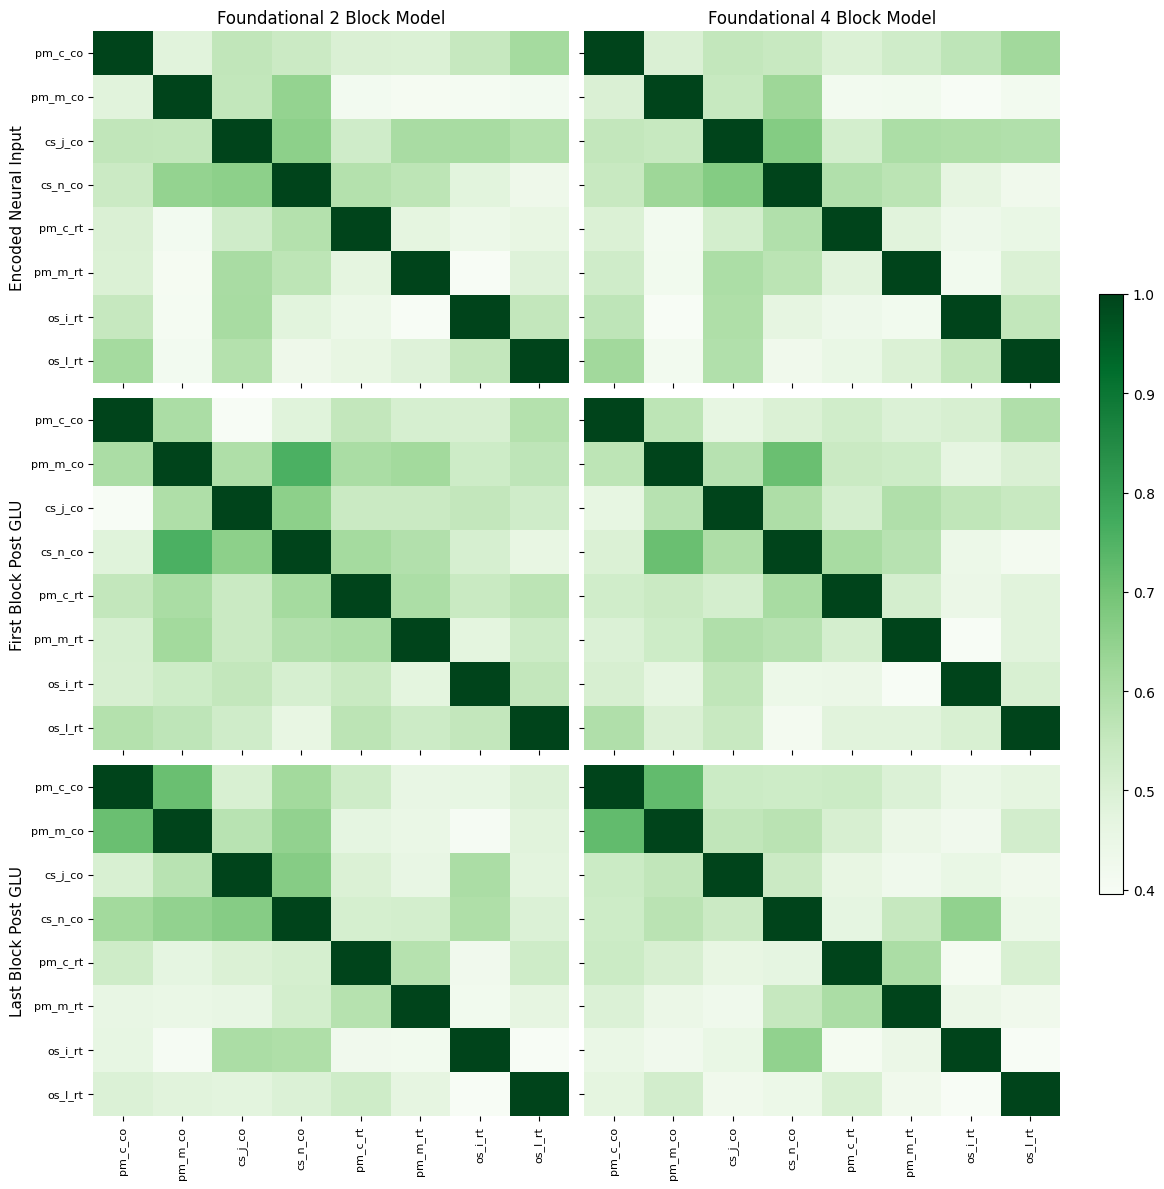

In [7]:
from foundational_ssm.constants import DATASET_IDX_TO_GROUP_SHORT
from neuralencoder.trajectories import plot_similarity_matrices_blocks

labels = [DATASET_IDX_TO_GROUP_SHORT[k] for k in data_keys]
plot_similarity_matrices_blocks(procrustes_2block, procrustes_4block, labels=labels)
#, save_path='/content/drive/MyDrive/Thesis/procrustes_blocks.pdf')


## Partipication Ratio Analysis

In [19]:
from neuralencoder.trajectories import pr_bootstrap

EPS = 1e-12
DEFAULT_KEYS = [
    'neural_input_raw', 'neural_input',
    'ssm_x_0','ssm_y_0', 'ssm_post_glu_0',
    'ssm_x_1','ssm_y_1', 'ssm_post_glu_1',
]

BLOCK4_KEYS = DEFAULT_KEYS + [
    'ssm_x_2','ssm_y_2', 'ssm_post_glu_2',
    'ssm_x_3','ssm_y_3', 'ssm_post_glu_3',
]

FOUND_2BLOCK_KEYS = [
    'post_encoder_raw', 'post_encoder',
    'ssm_x_0','ssm_y_0', 'ssm_post_glu_0',
    'ssm_x_1','ssm_y_1', 'ssm_post_glu_1',
]

FOUND_4BLOCK_KEYS = FOUND_2BLOCK_KEYS + [
    'ssm_x_2','ssm_y_2', 'ssm_post_glu_2',
    'ssm_x_3','ssm_y_3', 'ssm_post_glu_3',
]


#foundational_2block_pr = compute_pr_per_key(foundational_2block_data, FOUND_2BLOCK_KEYS)
foundational_2block_pr = pr_bootstrap(foundational_2block_data, FOUND_2BLOCK_KEYS)

100%|██████████| 8/8 [07:11<00:00, 53.91s/it]


In [ ]:
save_decoding_results(foundational_2block_pr, "/content/drive/MyDrive/Thesis/data/reaching_2block_pr_2.pkl.gz")

In [ ]:
foundational_4block_pr = pr_bootstrap(foundational_4block_data, FOUND_4BLOCK_KEYS)

100%|██████████| 14/14 [18:06<00:00, 77.61s/it]


In [ ]:
save_decoding_results(foundational_4block_pr, "/content/drive/MyDrive/Thesis/data/reaching_4block_pr_2.pkl.gz")

In [17]:
_FORMAT_TAG = "ssm_pr_results_v1"
import gzip, pickle

def load_decoding_results(path: str) -> dict:
    """
    Load results dict saved by save_results.
    """
    with gzip.open(path, "rb") as f:
        blob = pickle.load(f)
    if not isinstance(blob, dict) or blob.get("__format__") != _FORMAT_TAG:
        raise ValueError("File does not look like a saved results blob.")
    return blob["payload"]

foundational_2block_pr = load_decoding_results("/content/drive/MyDrive/Thesis/data/reaching_2block_pr_2.pkl.gz")
foundational_4block_pr = load_decoding_results("/content/drive/MyDrive/Thesis/data/reaching_4block_pr_2.pkl.gz")

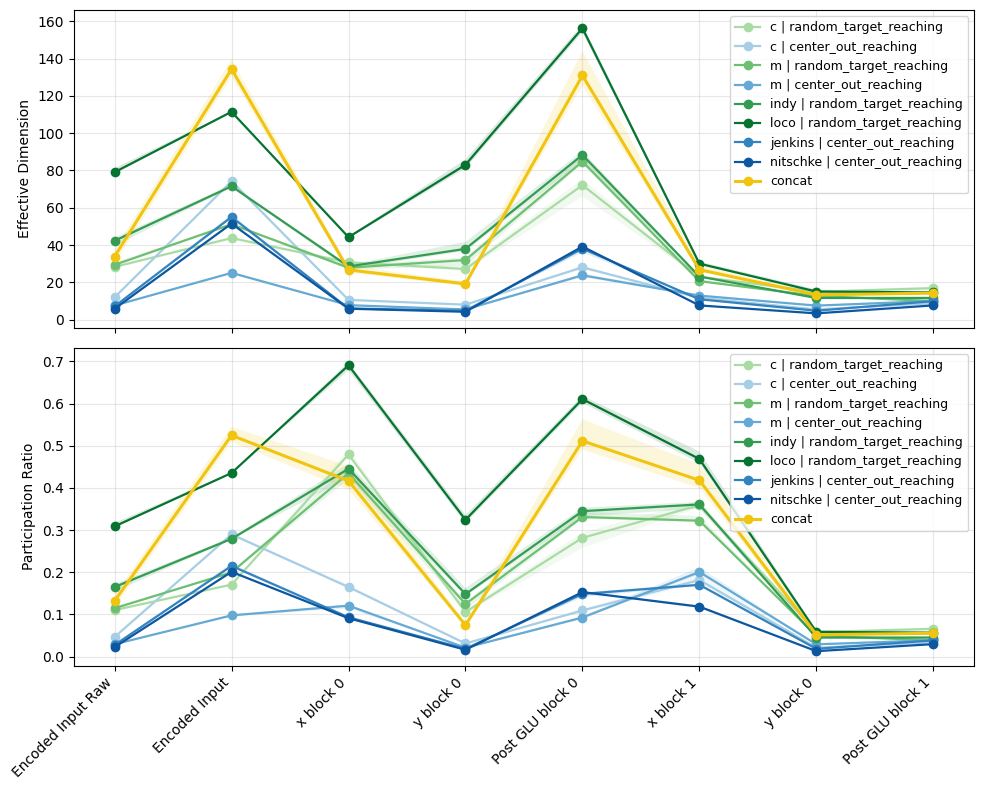

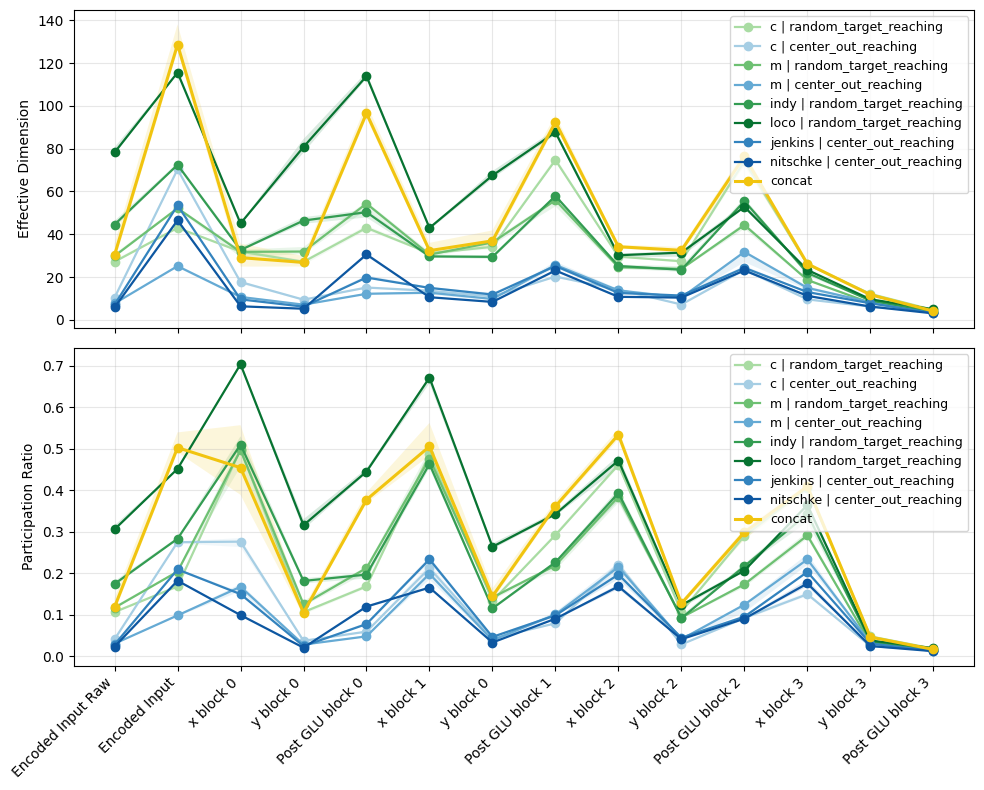

In [18]:
from neuralencoder.trajectories import plot_pr_results_with_ci_stacked

labels_map = {**DATASET_IDX_TO_GROUP_SHORT, 'concat': 'concatenated'}

labels = [
    'Encoded Input Raw', 'Encoded Input',
    'x block 0', 'y block 0','Post GLU block 0',
    'x block 1', 'y block 0','Post GLU block 1'
]

labels_4block = labels + [
    'x block 2', 'y block 2','Post GLU block 2',
    'x block 3', 'y block 3','Post GLU block 3'
]

plot_pr_results_with_ci_stacked({k:v for k,v in foundational_2block_pr.items()}, FOUND_2BLOCK_KEYS, labels)
plot_pr_results_with_ci_stacked({k:v for k,v in foundational_4block_pr.items()}, FOUND_4BLOCK_KEYS, labels_4block)

In [ ]:
#rtt_2block_pr = compute_pr_per_key(rtt_2block_data, FOUND_2BLOCK_KEYS, rtt=True)
rtt_2block_pr = pr_bootstrap(rtt_2block_data, FOUND_2BLOCK_KEYS, rtt=True)

100%|██████████| 8/8 [11:03<00:00, 82.93s/it]


In [ ]:
save_decoding_results(rtt_2block_pr, "/content/drive/MyDrive/Thesis/data/rtt_2block_pr_2.pkl.gz")

In [ ]:
rtt_2block_pr = load_decoding_results("/content/drive/MyDrive/Thesis/data/rtt_2block_pr.pkl.gz")

In [ ]:
rtt_4block_pr = pr_bootstrap(rtt_4block_data, BLOCK4_KEYS, rtt=True)

100%|██████████| 14/14 [33:27<00:00, 143.36s/it]


In [ ]:
save_decoding_results(rtt_4block_pr, "/content/drive/MyDrive/Thesis/data/rtt_4block_pr.pkl.gz")

In [ ]:
rtt_4block_pr = load_decoding_results("/content/drive/MyDrive/Thesis/data/rtt_4block_pr.pkl.gz")

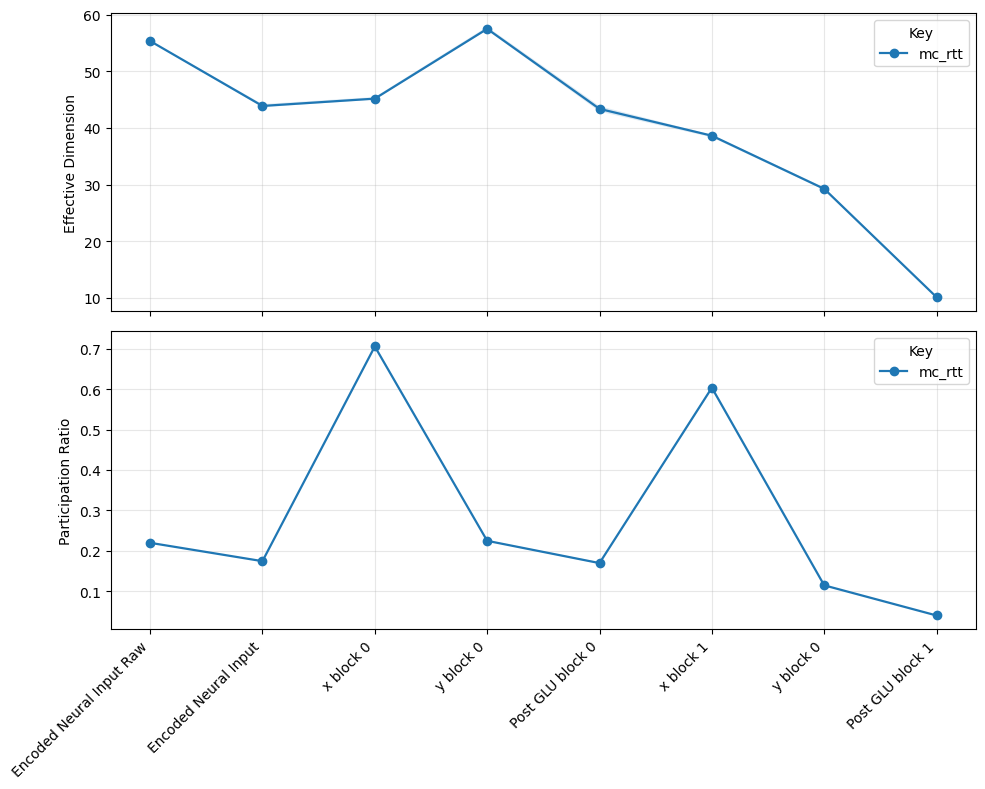

In [ ]:
labels_map = {**DATASET_IDX_TO_GROUP_SHORT, 'concat': 'concatenated', 55: 'mc_rtt'}

labels = [
    'Encoded Neural Input Raw', 'Encoded Neural Input',
    'x block 0', 'y block 0','Post GLU block 0',
    'x block 1', 'y block 0','Post GLU block 1'
]

labels_4block = labels + [
    'x block 2', 'y block 2','Post GLU block 2',
    'x block 3', 'y block 3','Post GLU block 3'
]

#plot_pr_results(rtt_2block_pr, FOUND_2BLOCK_KEYS, labels, ratio=True)
#plot_pr_results_with_ci({labels_map[k]:v for k,v in rtt_2block_pr.items()}, DEFAULT_KEYS, labels, ratio=False)
#plot_pr_results_with_ci({labels_map[k]:v for k,v in rtt_2block_pr.items()}, DEFAULT_KEYS, labels, ratio=True)
#plot_pr_results_with_ci({labels_map[k]:v for k,v in rtt_4block_pr.items()}, BLOCK4_KEYS, labels_4block, ratio=False)
#plot_pr_results_with_ci({labels_map[k]:v for k,v in rtt_4block_pr.items()}, BLOCK4_KEYS, labels_4block, ratio=True)

plot_pr_results_with_ci_stacked({labels_map[k]:v for k,v in rtt_2block_pr.items()}, FOUND_2BLOCK_KEYS, labels)

#plot_pr_results_with_ci_stacked({labels_map[k]:v for k,v in rtt_4block_pr.items()}, BLOCK4_KEYS, labels_4block)